# 1. 패키지 로드

In [1]:
from google.colab import drive

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# 2. 데이터 로드

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Titanic/train.csv', index_col = 'PassengerId')
test = pd.read_csv('/content/drive/MyDrive/Titanic/test.csv', index_col='PassengerId')
submission = pd.read_csv('/content/drive/MyDrive/Titanic/gender_submission.csv', index_col='PassengerId')

train.shape, test.shape, submission.shape

((891, 11), (418, 10), (418, 1))

In [4]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 3. 데이터 분석 시작

## 3-1. 타겟 변수 확인

In [5]:
# 타겟변수 간 불균형이 너무 심한 경우, 불균형을 해결한 후 머신러닝 알고리즘으로 학습시켜야 의미 있는 예측 가능.
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

## 3-2. 결측치 처리

In [6]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
 test.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [8]:
# 결측치 많은 열 삭제
train = train.drop(columns='Cabin')
test = test.drop(columns='Cabin')

# test Fare 결측치 0으로 채우기
test.loc[test['Fare'].isnull(),'Fare']=0

## 3-3. 성별

<Axes: xlabel='Sex', ylabel='count'>

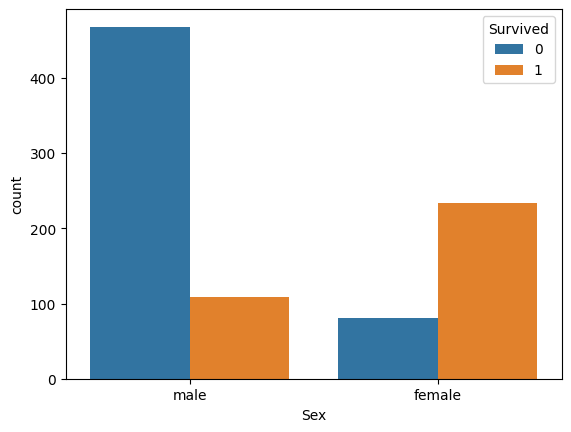

In [9]:
sns.countplot(data=train, x='Sex', hue='Survived')

In [10]:
train.loc[train['Sex']=='male', 'Sex'] = 0
train.loc[train['Sex']=='female', 'Sex'] = 1
test.loc[test['Sex']=='male', 'Sex'] = 0
test.loc[test['Sex']=='female', 'Sex'] = 1

In [11]:
train['Sex'][:5]

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Sex, dtype: object

In [12]:
test['Sex'][:5]

PassengerId
892    0
893    1
894    0
895    0
896    1
Name: Sex, dtype: object

## 3-4. Pclass(객실 등급)

<Axes: xlabel='Pclass', ylabel='count'>

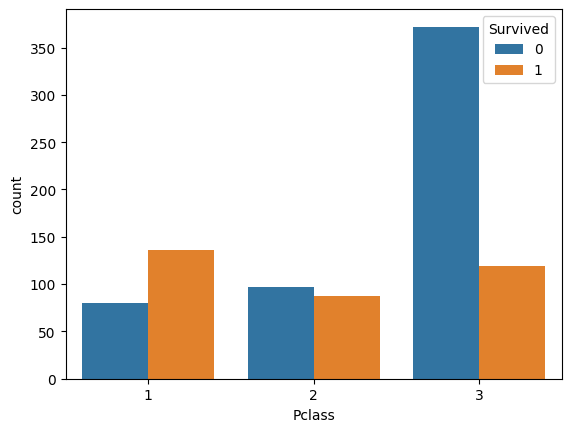

In [13]:
sns.countplot(data=train, x='Pclass', hue='Survived')

In [14]:
# One-hot Encoding
# 기존대로 Pclass에 숫자 1, 2, 3이 들어있으면, 해당 숫자들 간의 연산이 가능해져버림. 그러나 실제로는 1등석+2등석=3등석이 성립하는 것은 아님. => boolean으으로 바꿔.
train['Pclass_3'] = (train['Pclass']==3)
train['Pclass_2'] = (train['Pclass']==2)
train['Pclass_1'] = (train['Pclass']==1)

test['Pclass_3'] = (test['Pclass']==3)
test['Pclass_2'] = (test['Pclass']==2)
test['Pclass_1'] = (test['Pclass']==1)

In [15]:
# 더이상 필요 없어진 기존 Pclass 열은 삭제
train = train.drop(columns='Pclass')
test = test.drop(columns='Pclass')

## 3-5. 나이(Age)와 요금(Fare)

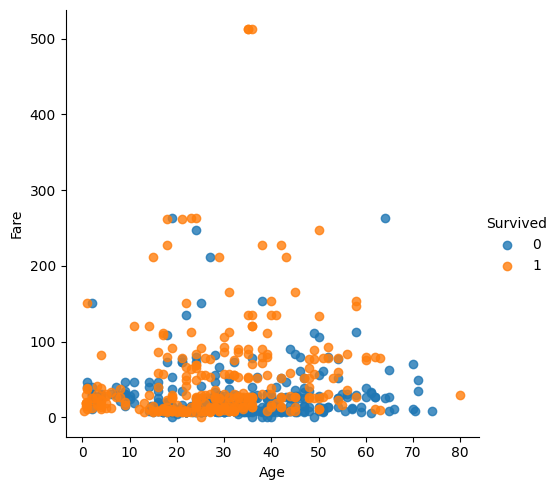

In [16]:
sns.lmplot(data=train, x='Age', y='Fare', fit_reg=False, hue='Survived')

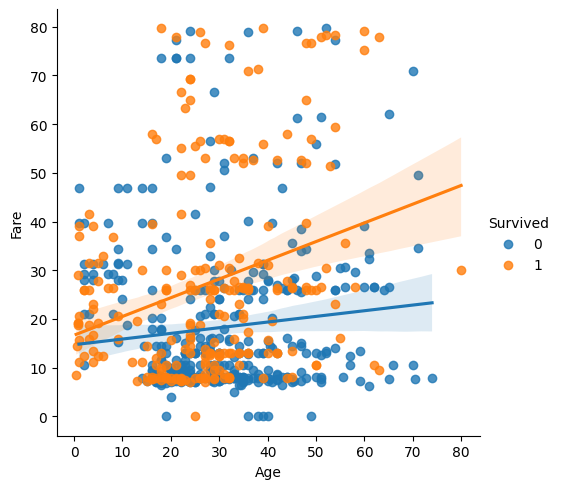

In [17]:
LowFare = train[train['Fare']<80]
sns.lmplot(data=LowFare, x='Age', y='Fare', hue='Survived')

In [18]:
# '나이' 항목은 요금과 상관관계가 딱히 보이지 않음. => 나이 변수 삭제
train = train.drop(columns='Age')
test = test.drop(columns='Age')

## 3-6. SibSp & Parch
- SIbSp: Sibling + Spouse
- Parch: Parents + Children

<Axes: xlabel='FamilySize', ylabel='count'>

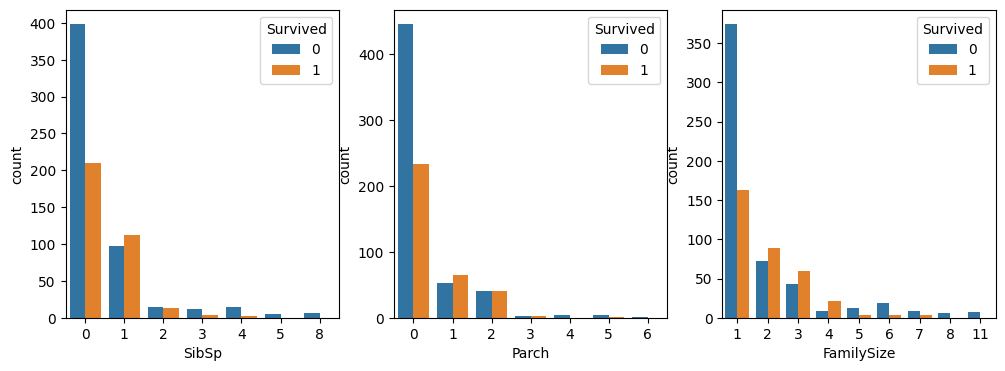

In [19]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(12, 4)
sns.countplot(data=train, x='SibSp', hue='Survived', ax=ax1)
sns.countplot(data=train, x='Parch', hue='Survived', ax=ax2)
sns.countplot(data=train, x='FamilySize', hue='Survived', ax=ax3)

#  FamilySize 가 2 ~ 4 인 경우에는 생존률이 더 높았다

<Axes: xlabel='Big', ylabel='count'>

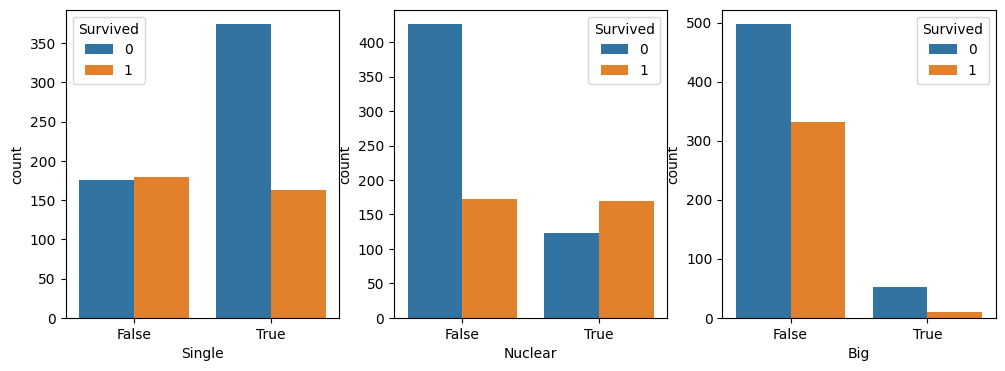

In [20]:
train['Single'] = train['FamilySize']==1
train['Nuclear'] = (2<=train['FamilySize']) & (train['FamilySize']<=4)
train['Big'] = train['FamilySize']>=5

test['Single'] = test['FamilySize']==1
test['Nuclear'] = (2<=test['FamilySize']) & (test['FamilySize']<=4)
test['Big'] = test['FamilySize']>=5

figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(12, 4)
sns.countplot(data=train, x='Single', hue='Survived', ax=ax1)
sns.countplot(data=train, x='Nuclear', hue='Survived', ax=ax2)
sns.countplot(data=train, x='Big', hue='Survived', ax=ax3)

# True 값을 유심히 봐야 함.
# 핵가족인 경우에만 생존률이 높았음. => Nuclear만 남기고 모두 지워주기.

In [21]:
train = train.drop(columns=['Single', 'Big', 'SibSp', 'Parch', 'FamilySize'])
test = test.drop(columns=['Single', 'Big', 'SibSp', 'Parch', 'FamilySize'])

## 3-7. 선착장 (Embarked)

<Axes: xlabel='Embarked', ylabel='count'>

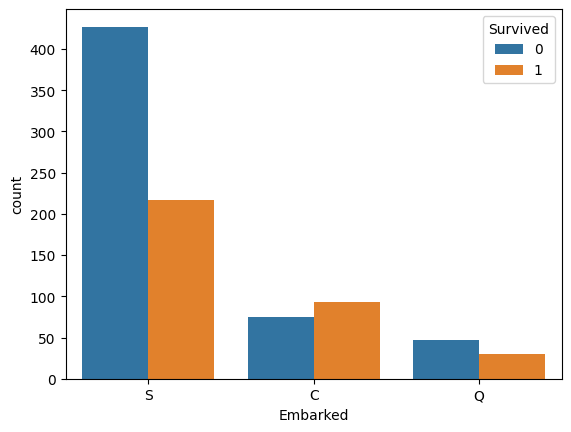

In [22]:
sns.countplot(data=train, x='Embarked', hue='Survived')

In [23]:
# One-hot Encoding
train['EmbarkedC'] = train['Embarked']=='C'
train['EmbarkedS'] = train['Embarked']=='S'
train['EmbarkedQ'] = train['Embarked']=='Q'

test['EmbarkedC'] = test['Embarked']=='C'
test['EmbarkedS'] = test['Embarked']=='S'
test['EmbarkedQ'] = test['Embarked']=='Q'

train = train.drop(columns='Embarked')
test = test.drop(columns='Embarked')

## 3-8. 이름(Name)

In [24]:
# 이름데이터: 이름, Mr. 성 으로 구성.
# 이름 데이터를 문자열로 받아서, 콤마와 온점 기준으로 가운데 있는 문자열(Mr, ...)을 가져오는 코드
train['Name'] = train['Name'].str.split(',').str[1].str.split('.').str[0]
test['Name'] = test['Name'].str.split(',').str[1].str.split('.').str[0]

In [25]:
train['Name']

PassengerId
1         Mr
2        Mrs
3       Miss
4        Mrs
5         Mr
       ...  
887      Rev
888     Miss
889     Miss
890       Mr
891       Mr
Name: Name, Length: 891, dtype: object

<Axes: xlabel='Name', ylabel='count'>

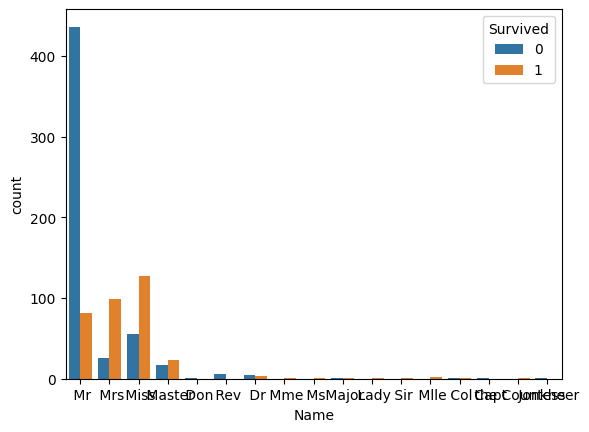

In [26]:
sns.countplot(data=train, x='Name', hue='Survived')
# Master 라는 호칭을 가진 남자(옛날 영어에서 어린 남자 지칭)의 생존률이 높았음.

In [27]:
# train과 test 에서 'Master' 여부 True or False 를 구분하는 변수를 만들고, 나머지 이름 데이터를 삭제
# 굳이 Ms, Mrs 를 같이 뽑지 않은 이유: 이미 얘네들은 여자이기 때문에, 머신러닝 알고리즘은 얘네들을 살 가능성이 높다고 판단할 것. 하지만 이 머신러닝은 남자들은 대부분 죽었다고 판단할 것.
# 우리가 데이터 분석을 하면서 정확도를 올릴 수 있는 방법은, 머신러닝이 죽었다고 판단할 남자들 중 살았을 확률이 높은 부분, 살았다고 판단했을 여자들이 죽었을 확률이 높은 부분을 찾아서 변수로 추가해주어야 정확도를 높일 수 있음.
# 여기서 Ms, Mrs 를 추가한다는것은 아무 의미 없이 변수만 늘리는 행위일 뿐 => 변수가 많아지면 결과에 좋은 영향을 끼치지 않을 가능성이 높음.

train['Master'] = (train['Name']=='Master')
test['Master'] = (test['Name']=='Master')

train = train.drop(columns='Name')
test = test.drop(columns='Name')

## 3-9. 티켓 (Ticket)

In [28]:
# 유의미한 상관관계 발견 못함. 그냥 삭제 고고.
train = train.drop(columns='Ticket')
test = test.drop(columns='Ticket')

# 4. 머신러닝 모델 생성 및 학습

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
y_train = train['Survived'] # 우리가 맞춰야 하는 생존 여부

feature_names = list(test)
X_train = train[feature_names] # 승객정보를 담고 있는 나머지 데이터에서 Survived를 제외한 나머지 열들
X_test = test[feature_names] # 승객정보를 담고 있는 나머지 데이터에서 Survived를 제외한 나머지 열들

X_train.shape, y_train.shape, X_test.shape
#  X_train 과 y_train의 행 수가 일치하는지, X_train 과 X_test 의 열 수가 일치하는지를 확인해야

((891, 10), (891,), (418, 10))

In [34]:
X_train.head()

,Sex,Fare,Pclass_3,Pclass_2,Pclass_1,Nuclear,EmbarkedC,EmbarkedS,EmbarkedQ,Master
PassengerId,,,,,,,,,,
1,0,7.2500,True,False,False,True,False,True,False,False
2,1,71.2833,False,False,True,True,True,False,False,False
3,1,7.9250,True,False,False,False,False,True,False,False
4,1,53.1000,False,False,True,True,False,True,False,False
5,0,8.0500,True,False,False,False,False,True,False,False


In [36]:
y_train.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

In [37]:
X_test.head()

,Sex,Fare,Pclass_3,Pclass_2,Pclass_1,Nuclear,EmbarkedC,EmbarkedS,EmbarkedQ,Master
PassengerId,,,,,,,,,,
892,0,7.8292,True,False,False,False,False,False,True,False
893,1,7.0000,True,False,False,True,False,True,False,False
894,0,9.6875,False,True,False,False,False,False,True,False
895,0,8.6625,True,False,False,False,False,True,False,False
896,1,12.2875,True,False,False,True,False,True,False,False


In [40]:
model = DecisionTreeClassifier(max_depth=8, random_state=18)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred[:5]

array([0, 1, 0, 0, 1])

In [41]:
submission['Survived'] = y_pred
submission.to_csv('Result.csv')
submission.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
